In [1]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import math
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from termcolor import colored as cl
from dotenv import load_dotenv
import os
plt.style.use('ggplot')
load_dotenv()

/home/codespace/.cache/pypoetry/virtualenvs/python-real-time-algo-trading-system-J101cbGx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-30 03:21:38.141325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 03:21:39.344816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 03:21:42.349705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 03:21:45.468687: W tensorflow/compiler/tf2tensorrt/utils/p

True

In [2]:
os.getenv("OANDA_ACCESS_TOKEN")

'b0ac81fa4d3fb91f1baa33015ed82104-c86dead361eb448ef07204a90b8fe7d9'

In [41]:
client = oandapyV20.API(access_token=os.getenv("OANDA_ACCESS_TOKEN"))

params = {'granularity': 'M10', 'count': 288}
r = instruments.InstrumentsCandles(instrument="USD_JPY",
                                   params=params)
client.request(r)

data = [{'time': d['time'], 
         'h': d['mid']['h'], 
         'c': d['mid']['c'], 
         'l': d['mid']['l'], 
         'o': d['mid']['o'], 
         'volume': d['volume']} 
        for d in r.response['candles']]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df = (df
      .set_axis(['time', 'high', 'close', 'low', 'open', 'volume'], axis=1)
      .assign(time= lambda x: pd.to_datetime(x['time']))
)
df[["high","low","close","open","volume"]] = df[["high","low","close","open","volume"]].apply(pd.to_numeric)

In [42]:
# create moving averages
spans = [3, 5, 10]
for span in spans:
    df[f"EMA_{span}"] = df["close"].ewm(span=span, adjust=False).mean()
    df[f"SMA_{span}"] = df["close"].rolling(window=span).mean()
    df[f"rolling_volume_{span}"] = df["volume"].rolling(window=span).mean()
    df[f"ROC_{span}"] = df["close"].pct_change(periods=span)

In [43]:
# create a column called RSI
delta = df["close"].diff()
gain = (delta.where(delta > 0, 0)).ewm(span=14).mean()
loss = (-delta.where(delta < 0, 0)).ewm(span=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

In [44]:
# create a column called MACD using 5, 13, 9
df["MACD"] = df["close"].ewm(span=5, adjust=False).mean() - df["close"].ewm(span=13, adjust=False).mean()

In [45]:
# create  bollinger bands for 10 minutes
rolling_mean = df["close"].rolling(window=10)
df["upper_band"] = rolling_mean.mean() + (rolling_mean.std() * 2)
df["lower_band"] = rolling_mean.mean() - (rolling_mean.std() * 2)

In [46]:
# stochastic oscillator for 5, 3, 3
df["%K"] = 100 * ((df["close"] - df["low"].rolling(window=5).min()) / (df["high"].rolling(window=5).max() - df["low"].rolling(window=5).min()))
df["%D"] = df["%K"].rolling(window=3).mean()


In [47]:
# ATR
df["TR"] = df[["high", "low", "close"]].diff().abs().max(axis=1)
df["ATR"] = df["TR"].rolling(window=14).mean()

In [48]:
# VWAP
df["VWAP"] = ((df["high"] + df["low"] + df["close"]) / 3 * df["volume"]).cumsum() / df["volume"].cumsum()

In [49]:
df["OBV"] = (np.sign(df["close"].diff()) * df["volume"]).fillna(0).cumsum()

In [50]:
df["future_close"] = df["close"].shift(-3)
# 10 pips
df["target"] = (df["future_close"] - df["close"]) > 0.01
df["target"].value_counts()

target
False    170
True     118
Name: count, dtype: int64

In [51]:
df.dropna(inplace=True)

In [52]:
df.columns

Index(['time', 'high', 'close', 'low', 'open', 'volume', 'EMA_3', 'SMA_3',
       'rolling_volume_3', 'ROC_3', 'EMA_5', 'SMA_5', 'rolling_volume_5',
       'ROC_5', 'EMA_10', 'SMA_10', 'rolling_volume_10', 'ROC_10', 'RSI',
       'MACD', 'upper_band', 'lower_band', '%K', '%D', 'TR', 'ATR', 'VWAP',
       'OBV', 'future_close', 'target'],
      dtype='object')

In [53]:
X = df.drop(["target", "future_close", "time"], axis=1)
y = df["target"]

In [55]:
train_test_split_index = int(0.6  * df.shape[0])
X_train = X[:train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]

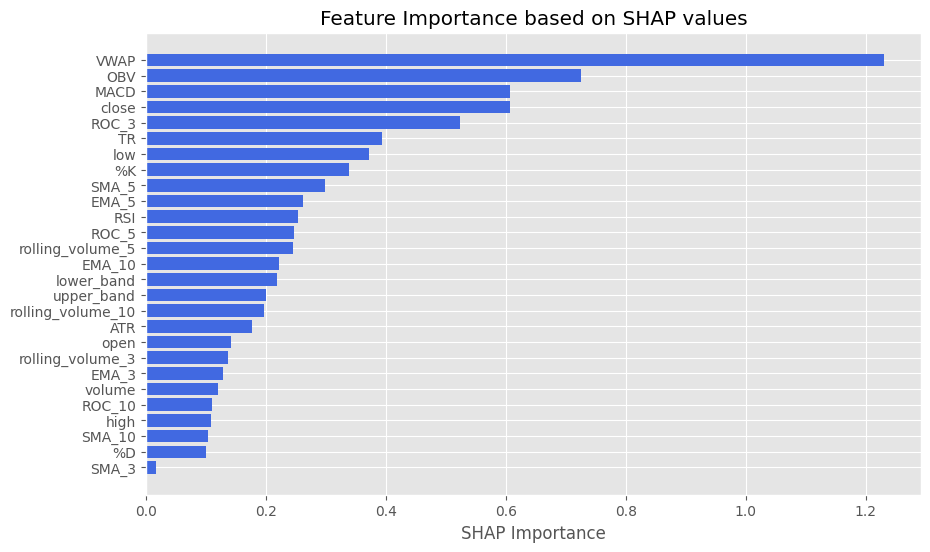

In [56]:
model = XGBClassifier()
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Assuming binary classification; adjust accordingly for multi-class
expected_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, list)
    else explainer.expected_value
)
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# Step 3: Summarize SHAP values in a DataFrame
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["feature", "shap_importance"]
importance_df["shap_importance"] = importance_df["shap_importance"].astype(float)
importance_df = importance_df.sort_values("shap_importance", ascending=False)

# Step 4: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["shap_importance"], color="royalblue")
plt.xlabel("SHAP Importance")
plt.title("Feature Importance based on SHAP values")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

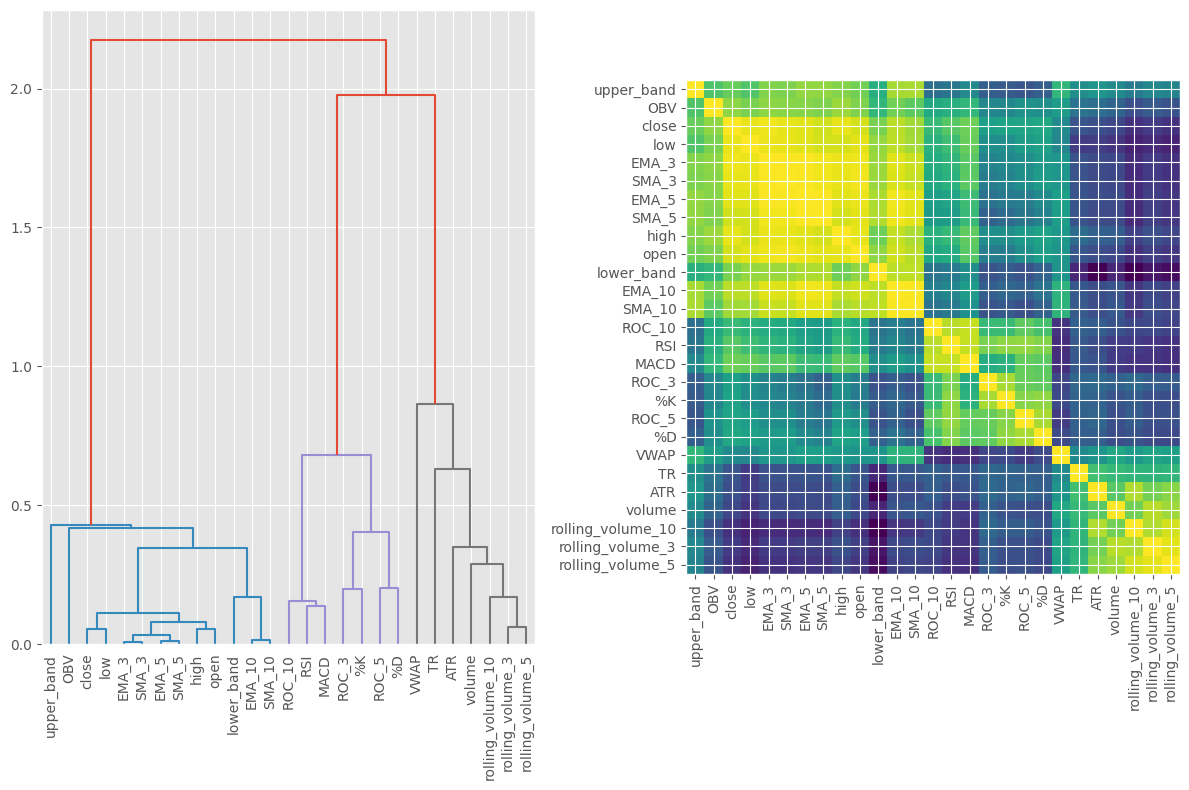

In [57]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [58]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]
print(cl("Selected features:", attrs=["bold"]), selected_features_names)

Selected features: Index(['high', 'volume', 'ROC_3'], dtype='object')


In [59]:
X_train_selected = X_train[selected_features_names]
X_test_selected = X_test[selected_features_names]

model.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
accuracy = accuracy_score(y_train, model.predict(X_train_selected))
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 1.0


In [61]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, model.predict(X_test_selected))
print(f"Model Precision: {precision}")

Model Precision: 0.4603174603174603


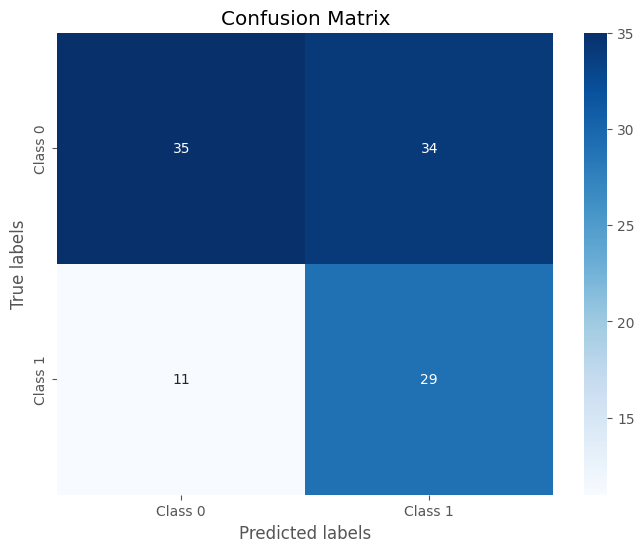

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred = model.predict(X_test_selected)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [63]:
import math
from termcolor import colored
def implement_strategy(df, investment, take_profit, stop_loss):
    in_position = False
    equity = investment
    no_of_shares = 0
    buy_price = None

    for i, row in df[selected_features_names].iterrows():
        y_pred_proba = model.predict_proba([row.values])[0]  # Ensure your model is defined and trained
        current_price = df['close'][i]
        profit_loss_ratio = 0 if buy_price is None else (current_price - buy_price) / buy_price      
        # Enter position based on confidence level
        if y_pred_proba[1] > 0.8 and not in_position:
            no_of_shares = math.floor(equity / current_price)
            equity -= no_of_shares * current_price
            in_position = True
            buy_price = current_price
            print(colored(f"BUY: {no_of_shares} Shares are bought at ${current_price}", 'green'))
        elif 0.6 < y_pred_proba[1] <= 0.8 and not in_position:
            no_of_shares = math.floor((equity / 2) / current_price)
            equity -= no_of_shares * current_price
            in_position = True
            buy_price = current_price
            print(colored(f"BUY: {no_of_shares} Shares are bought at ${current_price}", 'green'))

        # Check for sell conditions based on take-profit and stop-loss
        if in_position:
            if profit_loss_ratio >= take_profit:
                equity += no_of_shares * current_price
                print(colored(f"SELL: Take-Profit - {no_of_shares} Shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
            elif profit_loss_ratio <= -stop_loss:
                equity += no_of_shares * current_price
                print(colored(f"SELL: Stop-Loss - {no_of_shares} Shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
            elif 0.4 <= y_pred_proba[1] < 0.45 and in_position == True:
                # equity += no_of_shares * current_price * 0.5
                # no_of_shares *= 0.5
                # print(colored(f"SELL: Half of the shares are sold at ${current_price}", 'red'))
                print(colored(f"HOLD: {no_of_shares} Shares are held at ${current_price}", 'yellow'))
            elif y_pred_proba[1] < 0.4 and in_position == True:
                equity += no_of_shares * current_price
                print(colored(f"SELL: All remaining shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
            

    # Closing position at the end if still in position
    if in_position:
        equity += no_of_shares * current_price
        print(f"\nClosing position at ${current_price}")
        in_position = False

    earning = round(equity - investment, 2)
    roi = round((earning / investment) * 100, 2)
    print(f"EARNING: ${earning} ; ROI: {roi}%")
    
    return roi

In [64]:
implement_strategy(X_test, 10000, 0.01, 0.002)

BUY: 33 Shares are bought at $151.28
SELL: All remaining shares are sold at $151.341
BUY: 33 Shares are bought at $151.309
SELL: All remaining shares are sold at $151.304
BUY: 66 Shares are bought at $151.286
SELL: All remaining shares are sold at $151.286
BUY: 33 Shares are bought at $151.296
SELL: All remaining shares are sold at $151.272
BUY: 33 Shares are bought at $151.288
SELL: All remaining shares are sold at $151.341
BUY: 66 Shares are bought at $151.334
SELL: All remaining shares are sold at $151.356
BUY: 66 Shares are bought at $151.368
SELL: All remaining shares are sold at $151.365
BUY: 33 Shares are bought at $151.348
SELL: All remaining shares are sold at $151.368
BUY: 33 Shares are bought at $151.363
SELL: All remaining shares are sold at $151.351
BUY: 66 Shares are bought at $151.346
SELL: All remaining shares are sold at $151.334
BUY: 66 Shares are bought at $151.308
SELL: All remaining shares are sold at $151.332
BUY: 66 Shares are bought at $151.344
SELL: All remaini

0.1

In [65]:
import math
from termcolor import colored

def implement_strategy(df, investment, take_profit, stop_loss, max_minutes=1000, target_roi=0.3):
    in_position = False
    equity = investment
    no_of_shares = 0
    buy_price = None
    minutes_in_position = 0  # Track days in position
    target_equity = investment * (1 + target_roi)

    for i, row in df[selected_features_names].iterrows():
        y_pred_proba = model.predict_proba([row.values])[0]  # Ensure your model is defined and trained
        current_price = df['close'][i]
        profit_loss_ratio = 0 if buy_price is None else (current_price - buy_price) / buy_price

        if in_position and (equity >= target_equity or minutes_in_position >= max_minutes):
            equity += no_of_shares * current_price
            print(f"SELL: {no_of_shares} Shares are sold at ${current_price} due to ROI or time-based exit")
            in_position = False
            no_of_shares = 0
            buy_price = None
            break
        
        
        # Enter position based on confidence level
        if y_pred_proba[1] > 0.8 and not in_position:
            no_of_shares = math.floor(equity / current_price)
            equity -= no_of_shares * current_price
            in_position = True
            buy_price = current_price
            print(colored(f"BUY: {no_of_shares} Shares are bought at ${current_price}", 'green'))
        elif 0.6 <= y_pred_proba[1] <= 0.8 and not in_position:
            no_of_shares = math.floor((equity / 2) / current_price)
            equity -= no_of_shares * current_price
            in_position = True
            buy_price = current_price
            print(colored(f"BUY: {no_of_shares} Shares are bought at ${current_price}", 'green'))

        # Check for sell conditions based on take-profit and stop-loss
        if in_position:
            if profit_loss_ratio >= take_profit:
                equity += no_of_shares * current_price
                print(colored(f"SELL: Take-Profit - {no_of_shares} Shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
            elif profit_loss_ratio <= -stop_loss:
                equity += no_of_shares * current_price
                print(colored(f"SELL: Stop-Loss - {no_of_shares} Shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
            elif 0.4 <= y_pred_proba[1] < 0.6 and in_position == True:
                # equity += no_of_shares * current_price * 0.5
                # no_of_shares *= 0.5
                # print(colored(f"SELL: Half of the shares are sold at ${current_price}", 'red'))
                print(colored(f"HOLD: {no_of_shares} Shares are held at ${current_price}", 'yellow'))
            elif y_pred_proba[1] < 0.3 and in_position == True:
                equity += no_of_shares * current_price
                print(colored(f"SELL: All remaining shares are sold at ${current_price}", 'red'))
                in_position = False
                no_of_shares = 0
                buy_price = None
                
        total_value = round(equity + (no_of_shares * current_price), 2)
        earning = total_value - investment
        roi = round((earning / investment) * 100, 2)
        print(f"Current EARNING: ${earning} ; Current ROI: {roi}%")
        minutes_in_position += 10

    # Closing position at the end if still in position
    if in_position:
        equity += no_of_shares * current_price
        print(colored(f"\nClosing position at ${current_price}", 'red'))
        in_position = False

    earning = round(equity - investment, 2)
    roi = round((earning / investment) * 100, 2)
    print(f"EARNING: ${earning} ; ROI: {roi}%")
    
    return roi

# Note: `take_profit` and `stop_loss` should be provided as decimals (e.g., 0.05 for 5%)

In [66]:
implement_strategy(X_test, 1000000, 0.01, 0.002)

BUY: 3305 Shares are bought at $151.28
Current EARNING: $0.0 ; Current ROI: 0.0%
SELL: All remaining shares are sold at $151.341
Current EARNING: $201.59999999997672 ; Current ROI: 0.02%
Current EARNING: $201.59999999997672 ; Current ROI: 0.02%
BUY: 3305 Shares are bought at $151.309
Current EARNING: $201.59999999997672 ; Current ROI: 0.02%
SELL: All remaining shares are sold at $151.304
Current EARNING: $185.0799999999581 ; Current ROI: 0.02%
Current EARNING: $185.0799999999581 ; Current ROI: 0.02%
BUY: 6611 Shares are bought at $151.286
Current EARNING: $185.0799999999581 ; Current ROI: 0.02%
Current EARNING: $185.0799999999581 ; Current ROI: 0.02%
HOLD: 6611 Shares are held at $151.296
Current EARNING: $251.18999999994412 ; Current ROI: 0.03%
Current EARNING: $211.52000000001863 ; Current ROI: 0.02%
HOLD: 6611 Shares are held at $151.294
Current EARNING: $237.96999999997206 ; Current ROI: 0.02%
SELL: All remaining shares are sold at $151.297
Current EARNING: $257.80000000004657 ; Cu

0.1